# Inferenz Notebook
Das folgende Notebook liefert die Möglichkeit eigene Audiosamples auzunehmen oder hochzuladen und diese mit dem Modell zu resynthezisen.

In [ ]:
#@markdown 1. Diese Zelle zuerst ausführen für die Installation von bestimmten Versionen von Dependencies. Im Anschluss, wie vorgeschlagen, die Session neu starten. \
#@markdown (Es wird einige wenige, nicht kompatible Pakete geben. Diese werden aber nicht verwendet. Dauer ~1-3min)

!pip uninstall -y keras tensorflow tensorflow-probability absl-py astunparse flatbuffers gast google-pasta grpcio h5py keras keras-preprocessing libclang numpy opt-einsum protobuf setuptools six tensorboard tensorflow-io-gcs-filesystem termcolor tf-estimator-nightly typing-extensions wrapt
!pip install --disable-pip-version-check --no-cache-dir tensorflow==2.11.0
!pip install tensorflow-probability==0.15.0
!pip install keras==2.11.0

In [ ]:
#@markdown 2. Im Anschluss die Libary DDSP installieren und die Session wieder neustarten. \
#@markdown (Dauer ~2-3min)

!sudo apt-get install libportaudio2
!pip install -U ddsp[data_preparation]

Hier Session neustarten. Dann die Imports ausführen.

In [106]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from matplotlib import pyplot as plt

import datetime
import glob
import os
from google.colab import files
import librosa
from scipy.stats import wasserstein_distance

import tensorflow as tf

from ddsp.colab import colab_utils
import ddsp.training
from ddsp.training import (data, decoders, encoders, models, preprocessing,
                           train_util, trainers, metrics, nn)

# 16000 is the default sample rate of ddsp.
sample_rate = colab_utils.DEFAULT_SAMPLE_RATE

# Vorbereitung
In der Vorbereitung werden die Modellklassen und das Modell definiert sowie die Modellparameter geladen, um alles für das Testen vorzubereiten.  

## Model

In [ ]:
strategy = train_util.get_strategy()
tfkl = tf.keras.layers

## RNN-Fully Connected-Decoder
Hierbei handelt es sich um ein RNN mit zusätzlichem fully connected layer (FC)
am Ende für passende Outputs. In der Praxis erweisen sich gated recurrent units (gru) als performater im Verleich zu einem LSTM.

In [ ]:
class RnnFcDecoder(nn.DictLayer):

  def __init__(self,
               rnn_channels=512,
               rnn_type='gru',
               ch=512,
               layers_per_stack=3,
               input_keys=('ld_scaled', 'f0_scaled', 'z'),
               output_splits=(('amps', 1), ('harmonic_distribution', 40)),
               **kwargs):
    # Args:
    #   rnn_channels: number of dimensions for RNN layer
    #   rnn_type: 'lstm' or 'gru'
    #   ch: number of dimensions for fully connected layer
    #   layers_per_stack: number of fully connected layers per stack
    #   input_keys: create a fully connected stack for each input
    #   output_splits: splits the outputs into these dimensions
    #   **kwwargs: keras-specific kwargs

    # Returns:
    #   dictionary with keys from output_splits

    # Always put state as the last input and output.
    self.output_splits = output_splits
    output_keys = [v[0] for v in output_splits]

    super().__init__(input_keys=input_keys, output_keys=output_keys, **kwargs)

    stack = lambda: nn.FcStack(ch, layers_per_stack)
    n_stacks = len(self.input_keys)

    rnn_cls = nn.Rnn

    # Layers:
    self.input_stacks = [stack() for _ in range(n_stacks)]
    self.rnn = rnn_cls(rnn_channels, rnn_type)
    self.out_stack = stack()

    n_out = sum([v[1] for v in output_splits])
    self.dense_out = tfkl.Dense(n_out)

  def call(self, *inputs, **unused_kwargs):
    inputs = list(inputs)

    # Initial processing.
    inputs = [stack(x) for stack, x in zip(self.input_stacks, inputs)]

    # Run RNN.
    x = tf.concat(inputs, axis=-1)
    x = self.rnn(x)
    x = tf.concat(inputs + [x], axis=-1)

    # Final processing.
    x = self.out_stack(x)
    x = self.dense_out(x)

    output_dict = nn.split_to_dict(x, self.output_splits)

    return output_dict

## Dilated Convolutions
Hierbei handelt es sich um einen Decoder mit dilated convolution. Die Architektur ähnelt WaveNet mit zusätzlicher eindimenseonaler dilated convolution. Dilated bedeutet hier, dass die Größen der Lücken im Kernel mit jeder Schicht exponentiell zunehmen. \\
Im abgegebenen Modell wird diese Architektur *nicht* verwendet.

In [ ]:
class DilatedConvDecoder(nn.OutputSplitsLayer):


  def __init__(self,
               ch=256,
               kernel_size=3,
               layers_per_stack=5,
               stacks=2,
               dilation=2,
               norm_type='layer',
               resample_stride=1,
               stacks_per_resample=1,
               resample_after_convolve=True,
               input_keys=('ld_scaled', 'f0_scaled'),
               output_splits=(('amps', 1), ('harmonic_distribution', 60)),
               spectral_norm=False,
               ortho_init=False,
               **kwargs):
    # Args:
    #   ch: number of channels in each convolution layer
    #   layers_per_stack: number of convolution layers in each 'stack', dilation increases
    #     exponentially with layer depth inside a stack
    #   stacks: number of convolutions stacks
    #   kernel_size: size of convolution kernel
    #   dilation: exponent base of dilation factor within a stack
    #   norm_type: type of normalization before each nonlinearity, choose from
    #     'layer', 'instance', or 'group'
    #   resample_type: whether to 'upsample' or 'downsample' the signal
    #   resample_stride: stride for upsample or downsample layers
    #   stacks_per_resample: number of stacks per a resample layer
    #   resample_after_convolve: ordering of convolution and resampling; if True,
    #     apply 'stacks_per_resample' stacks of convolution then a resampling
    #     layer; Iif False, apply the opposite order
    #   spectral_norm: apply spectral normalization to the convolution weights
    #   ortho_init: orthogonally initialize the kernel weights
    #   **kwwargs: keras-specific kwargs

    input_keys = list(input_keys)
    super().__init__(input_keys, output_splits, **kwargs)


    # Layers.
    self.dilated_conv_stack = tf.keras.Sequential([
        nn.DilatedConvStack(
            ch=ch,
            kernel_size=kernel_size,
            layers_per_stack=layers_per_stack,
            stacks=stacks//2,
            dilation=dilation,
            norm_type=norm_type,
            resample_type='upsample' if resample_stride > 1 else None,
            resample_stride=resample_stride,
            stacks_per_resample=stacks_per_resample,
            resample_after_convolve=resample_after_convolve,
            spectral_norm=spectral_norm,
            ortho_init=ortho_init),
        tfkl.ReLU(),
        nn.DilatedConvStack(
            ch=ch,
            kernel_size=kernel_size,
            layers_per_stack=layers_per_stack,
            stacks=stacks//2,
            dilation=dilation,
            norm_type=norm_type,
            resample_type='upsample' if resample_stride > 1 else None,
            resample_stride=resample_stride,
            stacks_per_resample=stacks_per_resample,
            resample_after_convolve=resample_after_convolve,
            spectral_norm=spectral_norm,
            ortho_init=ortho_init),
        tfkl.ReLU()
    ])

  def _parse_inputs(self, inputs):
      return tf.concat(inputs, axis=-1)

  def compute_output(self, *inputs):
        stack_inputs = self._parse_inputs(inputs)
        return self.dilated_conv_stack(stack_inputs)

## Modell aufsetzen
Hier wird das Modell aufgesetzt, wo die Hyperparameter des Netzes variiert werden können.

In [126]:
# Rescaling of loudness.
preprocessor = preprocessing.F0LoudnessPreprocessor()

# RNN with fully connected layer.
decoder = RnnFcDecoder(rnn_channels = 256, #512
                              rnn_type = 'gru',
                              ch = 256, #512
                              layers_per_stack = 2, #3
                              input_keys = ('ld_scaled', 'f0_scaled'),
                              output_splits = (('amps', 1),
                                               ('harmonic_distribution', 60),
                                               ('noise_magnitudes', 65)))

# Dilated convolution decoder.
# decoder = DilatedConvDecoder(ch=128,
#                             kernel_size=3,
#                             layers_per_stack=8,
#                             stacks=2,
#                             dilation=2,
#                             norm_type='layer',
#                             resample_stride=0,
#                             stacks_per_resample=0,
#                             resample_after_convolve=True,
#                             spectral_norm=False,
#                             ortho_init=False,
#                             input_keys = ('ld_scaled', 'f0_scaled'),
#                             output_splits = (('amps', 1),
#                                              ('harmonic_distribution', 60),
#                                              ('noise_magnitudes', 65)))


# Create the two synths and the merge them together.
harmonic = ddsp.synths.Harmonic(n_samples=4*sample_rate,
                                sample_rate=sample_rate,
                                name='harmonic')

noise = ddsp.synths.FilteredNoise(window_size=0,
                                  initial_bias=-10.0,
                                  name='noise')
add = ddsp.processors.Add(name='add')

reverb = ddsp.effects.Reverb(trainable=True,
                             reverb_length=3*sample_rate,
                             name='reverb')

# Make one Tensorflow-Layer out of the processors.
dag = [(harmonic, ['amps', 'harmonic_distribution', 'f0_hz']),
       (noise, ['noise_magnitudes']),
       (add, ['noise/signal', 'harmonic/signal']),
       (reverb, ['add/signal'])]

processor_group = ddsp.processors.ProcessorGroup(dag=dag, name='processor_group')

# Loss_function.
spectral_loss = ddsp.losses.SpectralLoss(loss_type='L1',
                                         mag_weight=1.0,
                                         logmag_weight=1.0)

# Combine everything into the model.
with strategy.scope():
    model = models.Autoencoder(preprocessor=preprocessor,
                                encoder=None,
                                decoder=decoder,
                                processor_group=processor_group,
                                losses=[spectral_loss],
                                name="autoencoder")

    trainer = trainers.Trainer(model, strategy)

## Modell-Parameter laden
Hier können Modelle mit trainierten Parametern als zip hochgeladen werden.

In [125]:
UPLOAD_DIR = '/content/uploaded'
!mkdir $UPLOAD_DIR
uploaded_files = files.upload()

for fnames in uploaded_files.keys():
  print("Unzipping... {}".format(fnames))
  !unzip -o "/content/$fnames" -d $UPLOAD_DIR &> /dev/null


mkdir: cannot create directory ‘/content/uploaded’: File exists


Saving model.zip to model.zip
Unzipping... model.zip


In [127]:
# Identification of checkpoint-file.
ckpt_files = [f for f in tf.io.gfile.listdir(UPLOAD_DIR) if 'ckpt' in f]
ckpt_name = ckpt_files[0].split('.')[0]
ckpt = os.path.join(UPLOAD_DIR, ckpt_name)
print(ckpt)

/content/uploaded/ckpt-5700


In [128]:
# Loading checkpoint.
# An error occurs, if the configuration of the model and the checkpoint do not match.
model.restore(ckpt)

# Inferenz
Im Folgenden können Audios aufgenommen oder hochgeladen werden, um diese als Eingabe für das Modell zu verwenden.

## Variante A) Testdatensatz

Wir verwenden Google-Drive für die Trainingsdaten. Die Trainingsdaten werden in einen lokalen Ordner kopiert und dort verarbeitet. Wichtige Daten, wie vorverarbeitete Trainingsdaten und Checkpoints, werden zur Sicherung ins Drive kopiert.

In [111]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [112]:
#@markdown Google Drive Ordner mit mp3/wav Trainingsdaten (Beispielordner: `/content/drive/MyDrive/...`)
DRIVE_DIR = '/content/drive/MyDrive/Informatikstudium/s5/dl/projekt/duesi' #@param {type: "string"}

assert os.path.exists(DRIVE_DIR)
print('Drive Folder Exists:', DRIVE_DIR)

Drive Folder Exists: /content/drive/MyDrive/Informatikstudium/s5/dl/projekt/duesi


### Testdatensatz laden
Lade/Erstelle den Datensatz. Das Laden von einem bestehenden Datensatz geht schnell. Das Vorverarbeiten für einen neuen Datensatz dauert etwa 2 Stunden pro 10 Minuten Trainingsaudio.

Bei der Verarbeitung werden sehr wahrscheinlich einige Warnungen ausgegeben. Dabei handelt es sich um stille Abschnitte der Audiodatei mit einer Lautstärke von 0. Diese werden bei der Aufbereitung herausgefiltert.

In [114]:
# Make dir for saving the checkpoints.
SAVE_DIR = os.path.join(DRIVE_DIR, 'model')
!mkdir -p "$SAVE_DIR"

phases = ['test']
# Dataset for each phase.
dataset = {}

for phase in phases:
    PHASE_DRIVE_DIR = os.path.join(DRIVE_DIR, phase)

    # Make local directories.
    AUDIO_DIR = os.path.join(phase, 'data/audio')
    AUDIO_FILEPATTERN = AUDIO_DIR + '/*'
    !mkdir -p $AUDIO_DIR

    mp3_files = glob.glob(os.path.join(PHASE_DRIVE_DIR, '*.mp3'))
    wav_files = glob.glob(os.path.join(PHASE_DRIVE_DIR, '*.wav'))
    audio_files = mp3_files + wav_files

    print(PHASE_DRIVE_DIR)

    for file_name in audio_files:
        target_name = os.path.join(AUDIO_DIR, os.path.basename(file_name).replace(' ', '_'))
        print('Copying {} to {}'.format(file_name, target_name))
        !cp "$file_name" $target_name

    TFRECORD = os.path.join(phase, 'data/train.tfrecord')
    TFRECORD_FILEPATTERN = TFRECORD + '*'

    # Copy dataset from drive if dataset has already been created.
    drive_data_dir = os.path.join(PHASE_DRIVE_DIR, 'data')
    drive_dataset_files = glob.glob(drive_data_dir + '/*')

    # Find already processed dataset on drive.
    if len(drive_dataset_files) > 0:
        print(f"Found {phase} dataset in Drive. Copying to local files...")
        TARGET = os.path.join(phase, 'data')
        !cp "$drive_data_dir"/* $TARGET/

    # Else create new Dataset.
    else:
        if not glob.glob(AUDIO_FILEPATTERN):
            raise ValueError(f'No audio files found in {AUDIO_FILEPATTERN}!')

        !ddsp_prepare_tfrecord \
            --input_audio_filepatterns=$AUDIO_FILEPATTERN \
            --output_tfrecord_path=$TFRECORD \
            --num_shards=10 \
            --alsologtostderr

        # Copy dataset to drive for safe-keeping.
        if DRIVE_DIR:
            !mkdir "$drive_data_dir"/
            print('Saving to {}'.format(drive_data_dir))
            !cp $TFRECORD_FILEPATTERN "$drive_data_dir"/

    data_provider = ddsp.training.data.TFRecordProvider(TFRECORD_FILEPATTERN)
    dataset[phase] = data_provider.get_dataset(shuffle=False)

/content/drive/MyDrive/Informatikstudium/s5/dl/projekt/duesi/test
Copying /content/drive/MyDrive/Informatikstudium/s5/dl/projekt/duesi/test/duesi_test.wav to test/data/audio/duesi_test.wav
Found test dataset in Drive. Copying to local files...


Prediction für den gesamten Testdatensatz. (Dauert einige Minuten)

Predicting batch 1/16
Predicting batch 2/16
Predicting batch 3/16
Predicting batch 4/16
Predicting batch 5/16
Predicting batch 6/16
Predicting batch 7/16
Predicting batch 8/16
Predicting batch 9/16
Predicting batch 10/16
Predicting batch 11/16
Predicting batch 12/16
Predicting batch 13/16
Predicting batch 14/16
Predicting batch 15/16
Predicting batch 16/16
Original Audio


Resynthesized Audio


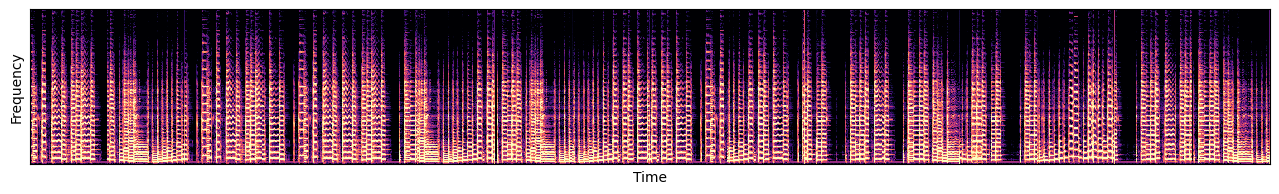

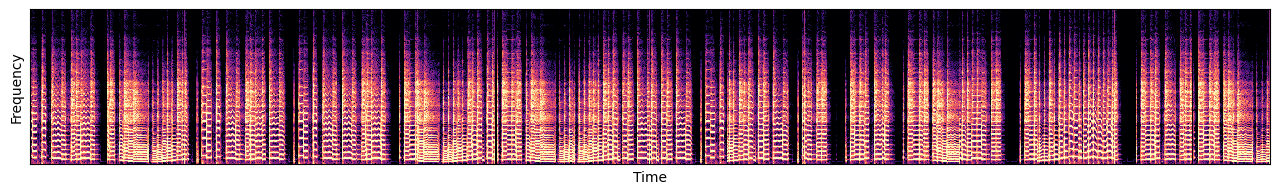

In [129]:
audio = np.empty([1])
audio_gen = np.empty([1])
num_batches = 16 # Select only a part of the test-dataset. max. 119.

for i, data in enumerate (dataset['test']):
  print(f"Predicting batch {i+1}/{num_batches}")
  audio_section = data['audio']

  controls =  model(data)
  audio_gen_section = model.get_audio_from_outputs(controls)

  audio = np.concatenate([audio, audio_section])
  audio_gen = np.concatenate([audio_gen, audio_gen_section[0]])

  if i+1 >= num_batches: break

print('Original Audio')
colab_utils.play(audio)
print('Resynthesized Audio')
colab_utils.play(audio_gen)

colab_utils.specplot(audio)
colab_utils.specplot(audio_gen)

In [ ]:
loudness = ddsp.spectral_ops.compute_loudness(
      audio, sample_rate=sample_rate,
      frame_rate=250)

loudness_gen = ddsp.spectral_ops.compute_loudness(
      audio_gen, sample_rate=sample_rate,
      frame_rate=250)


loudness_difference = np.abs(loudness_gen - loudness)

print(f"Loudness Difference on test-Dataset: {loudness_difference}")

### Wasserstein-Differenz

In [ ]:
def compute_spectral_wasserstein_distance(audio1, audio2):
    # Compute STFT
    D1 = np.abs(librosa.stft(audio1[0]))
    D2 = np.abs(librosa.stft(audio2[0]))

    # Wasserstein distance for each frequency band
    distances = []
    for i in range(D1.shape[0]):
        wd = wasserstein_distance(D1[i, :], D2[i, :])
        distances.append(wd)

    # Spectral Wasserstein distance
    spectral_wd = np.mean(distances)
    return spectral_wd


spectral_wd = compute_spectral_wasserstein_distance(np.array(audio), np.array(audio_gen))
print(f"Spectral Wasserstein Distance: {spectral_wd}")

## Variante B) Audio Datei laden/erstellen
Wähle Aufnehmen oder Hochladen für die Test-Datei aus und führe folgende Zelle aus, um die Aufnahme/den Upload zu beginnen:

Saving mas_que_nada.wav to mas_que_nada.wav


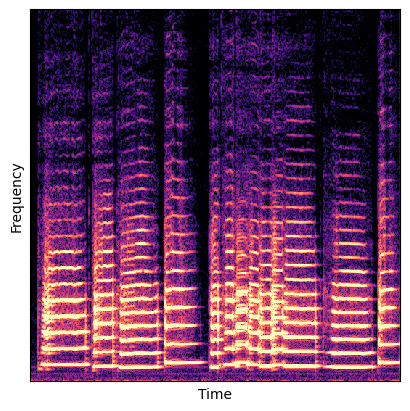

In [ ]:
record_or_upload = "Hochladen (.mp3 or .wav)"  #@param ["Aufnehmen", "Hochladen (.mp3 or .wav)"]
record_seconds = 4

if (record_or_upload == "Aufnehmen"):
  audio = colab_utils.record(seconds=record_seconds)
else:
  filenames, audios = colab_utils.upload()
  audio = audios[0]

colab_utils.play(audio)
colab_utils.specplot(audio)

Das Audio wird auf 4 Sekunden getrimmt, um vom Modell verarbeitet werden zu können.

In [ ]:
if len(audio.shape) == 1:
  audio = audio[np.newaxis, :]
if len(audio[0]) > 64000:
    # Cut audio to 4 seconds.
    audio = audio[:, :64000]
elif len(audio[0]) < 64000:
    # Pad audio with zeros up to the desired length of 4 seconds.
    audio = np.concatenate([audio, np.zeros(64000 - len(audio[0]))[np.newaxis, :]], axis=1)

Die Audio-Features werden aus dem Audio extrahiert. Dies kann einige Minuten dauern.

{'audio': (1, 64000), 'loudness_db': TensorShape([1001]), 'f0_hz': (1001,), 'f0_confidence': (1001,)}


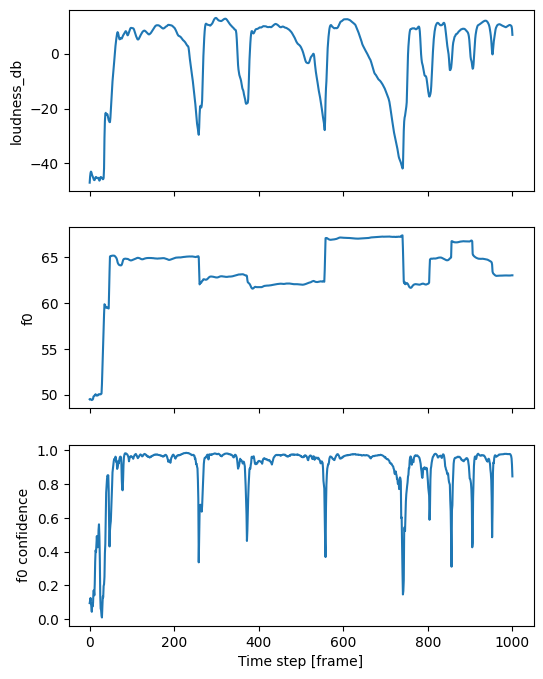

In [ ]:
# Extractination of audio features.
audio_features = ddsp.training.metrics.compute_audio_features(audio)

print({k: v.shape for k, v in audio_features.items()})

# Plot features.
fig, ax = plt.subplots(nrows=3,
                       ncols=1,
                       sharex=True,
                       figsize=(6, 8))
ax[0].plot(audio_features['loudness_db'])
ax[0].set_ylabel('loudness_db')

ax[1].plot(librosa.hz_to_midi(audio_features['f0_hz']))
ax[1].set_ylabel('f0')

ax[2].plot(audio_features['f0_confidence'])
ax[2].set_ylabel('f0 confidence')
_ = ax[2].set_xlabel('Time step [frame]')

#Vorbearbeitung des Audios
Hier kann das Audio nochmals bearbeitet werden, um es den Trainingsdaten anzunähern. Es können Tonhöhe und Lautstärke angepasst werden, wodurch beispielsweise eine tiefe Stimme schon zuvor in der Tonlage erhöht werden kann, womit das Audio näher an der hohen E-Gitarre liegt. Dies bewirkt einen realistischeren Klangeindruck des vom Modell generierten Audios.

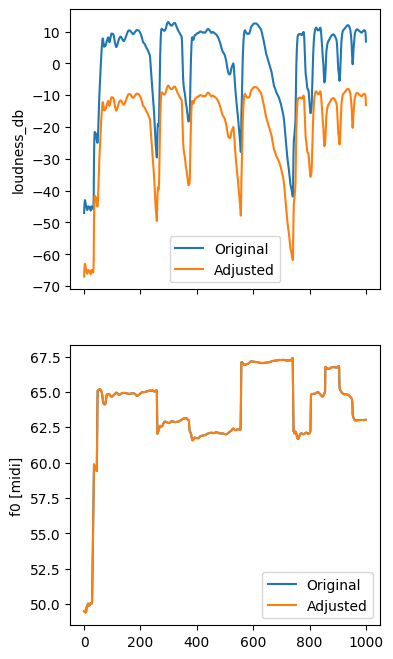

In [108]:
#@markdown ## Manuelle Anpassung


#@markdown Verändere die Tonhöhe (Okatven):
pitch_shift =  0 #@param {type:"slider", min:-2, max:2, step:1}

#@markdown Passe die Lautstärke an (dB):
loudness_shift = 0 #@param {type:"slider", min:-20, max:20, step:1}


audio_features_mod = {k: np.array(v) for k, v in audio_features.items()}


## Helper functions.
def shift_ld(audio_features, ld_shift=0.0):
  """Shift loudness by a number of ocatves."""
  audio_features['loudness_db'] += ld_shift
  return audio_features


def shift_f0(audio_features, pitch_shift=0.0):
  """Shift f0 by a number of ocatves."""
  audio_features['f0_hz'] *= 2.0 ** (pitch_shift)
  audio_features['f0_hz'] = np.clip(audio_features['f0_hz'],
                                    0.0,
                                    librosa.midi_to_hz(110.0))
  return audio_features


# Manual Shifts.
audio_features_mod = shift_ld(audio_features_mod, loudness_shift)
audio_features_mod = shift_f0(audio_features_mod, pitch_shift)


# Plot Features.
n_plots = 3 if has_mask else 2
fig, axes = plt.subplots(nrows=n_plots,
                      ncols=1,
                      sharex=True,
                      figsize=(2*n_plots, 8))

ax = axes[0]
ax.plot(audio_features['loudness_db'])
ax.plot(audio_features_mod['loudness_db'])
ax.set_ylabel('loudness_db')
ax.legend(['Original','Adjusted'])

ax = axes[1]
ax.plot(librosa.hz_to_midi(audio_features['f0_hz']))
ax.plot(librosa.hz_to_midi(audio_features_mod['f0_hz']))
ax.set_ylabel('f0 [midi]')
_ = ax.legend(['Original','Adjusted'])


Generierung des resynthezied Audios durch das Modell:

Original


Resynthesis


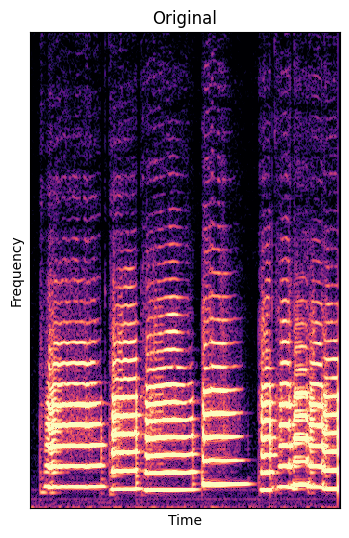

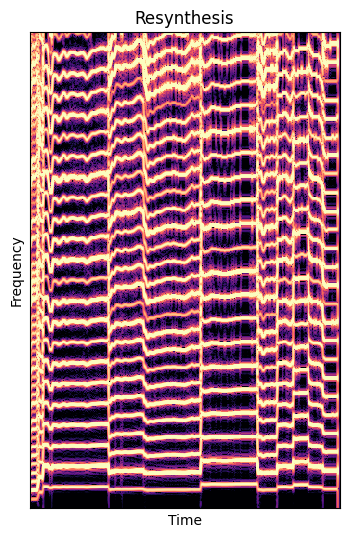

In [109]:
af = audio_features_mod if audio_features_mod is not None else audio_features

outputs = model(af)
audio_gen = model.get_audio_from_outputs(outputs)

# Plot.
print('Original')
colab_utils.play(audio)

print('Resynthesis')
colab_utils.play(audio_gen)

colab_utils.specplot(audio)
plt.title("Original")

colab_utils.specplot(audio_gen)
_ = plt.title("Resynthesis")